#### Problem:

Find a simple way to measure the 'importance' of a team in the market

#### Idea:

Measure the centrality of a team as a function of its degree/strength in all the network, in relationship to the degree/strength of the teams of its league

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from igraph import Graph
import igraph as ig

Just a function to retrieve the teams of each league

In [47]:
leagues = pd.read_csv('resources/club_league.csv')

def get_league_teams(league):
    lea = leagues[leagues['league_name']==league]['club_name'].values
    lea = np.append(lea, [l+'_seller' for l in lea])
    return lea

Centrality measure based on this article (but using strenght instead of degree): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2175124/

In [184]:
def get_centrality(g, club, league, weights='weight'):
    
    ids = np.array(g.vs['id'])
    buyer_idx  = np.where(ids == club)[0]
    seller_idx = np.where(ids == club+'_seller')[0]
    league_idxs = np.where(np.isin(ids, league))[0]

    # If you pass weighs=None, it will just work with the normal degrees as in the original paper
    strengths = np.array(g.strength(weights=weights))
    strengths_league = strengths[league_idxs]
    strenght_buyer = strengths[buyer_idx]
    strenght_seller = strengths[seller_idx]
    
    z_buyer  = (strenght_buyer  - np.mean(strengths_league))/np.std(strengths_league)
    z_seller = (strenght_seller - np.mean(strengths_league))/np.std(strengths_league)


    # Return a vector with three elements: the centrality for the buyer, for the seller and the total
    z = np.zeros(3)
    
    if buyer_idx.size > 0:  z[0] = z_buyer
    if seller_idx.size > 0: z[1] = z_seller
    z[2] = z[0]*z[1] # Not sure if this is the best way to combine the two indicators tho
    
    return z

Function to compute the centrality for a bunch of years (requires a single network for each year)

In [185]:
def get_centrality_years(teams, league, year_from, year_to, plot=True):

    years = [year for year in range(year_from, year_to+1, 1)]
    league_teams = get_league_teams(league)

    fee  = np.zeros((len(teams), len(years), 3))
    freq = np.zeros((len(teams), len(years), 3))
    for i, year in enumerate(years):

        g_fee  = Graph.Load('nets/{}/fee_net.net'.format(year))
        g_freq = Graph.Load('nets/{}/freq_net.net'.format(year))

        for j, t in enumerate(teams):
            fee[j, i]  = get_centrality(g_fee, t, league_teams)
            freq[j, i] = get_centrality(g_freq, t, league_teams)


    if plot:
        #Plot fee
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        if len(teams) > 1: # In the case more than one team is passed, plot only the total
            for i, t in enumerate(teams):
                plt.plot(years, fee[i,:,2],LineWidth=0.8, label=t+'_total')
        else:
            plt.plot(years, fee[0,:,0],'g-',LineWidth=0.4, label=t+'_buyer')
            plt.plot(years, fee[0,:,1],'r-',LineWidth=0.4, label=t+'_seller')
            plt.plot(years, fee[0,:,2],'b-',LineWidth=0.8, label=t+'_total')
        plt.title('Fee Centrality')
        plt.legend()
        plt.show()

        #Plot freq
        plt.figure(figsize=(10,10))
        plt.subplot(212)
        if len(teams) > 1:
            for i, t in enumerate(teams):
                plt.plot(years, freq[i,:,2],LineWidth=0.8, label=t+'_total')
        else:
            plt.plot(years, freq[0,:,0],'g-',LineWidth=0.4, label=t+'_buyer')
            plt.plot(years, freq[0,:,1],'r-',LineWidth=0.4, label=t+'_seller')
            plt.plot(years, freq[0,:,2],'b-',LineWidth=1, label=t+'_total')
        plt.title('Freq Centrality')
        plt.legend()
        plt.show()
        
    return fee_values, freq_values 

The fee plot for Inter make a lot of sense to me: what I was expecting indeed was a great peak around the 2010, when we won the triplete and we were at the top of the italian football. It was just a couple of years of glory: before and after we returned back to our average level. It's interesting in my opinion that we can see this peak in the graph: for me it means that this measure can more or less grasp the level of importance of a team

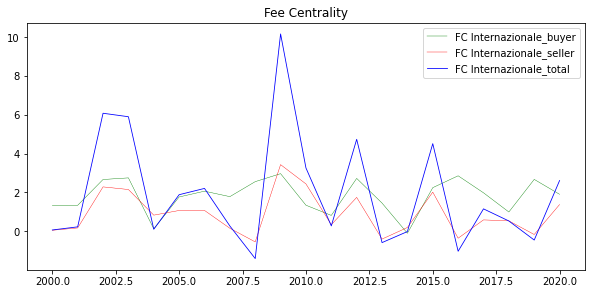

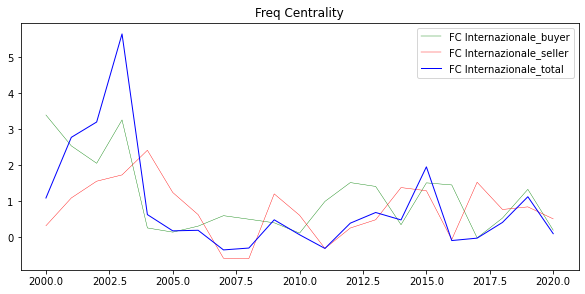

In [186]:
_ = get_centrality_years(teams=['FC Internazionale'], league='Serie A', year_from=2000, year_to=2020)

Also the plot for the juventus makes sense for me, I don't know if you know what happen around the 2006, but there was a huge scandle called 'Calcioscommesse' that forced Juventus to retroced in Serie B. Thiss is very visible in the freq graph, but also in the fee graph. In general, the buyer the importance of Juventus decreased from the previous years, but increased as a seller: many players were sold and few were bought. Moreover, from 2014 Juventus made a very huge investement plan that allowed it to become the most important team in italy in a couple of years. This is very visible in the first graph.

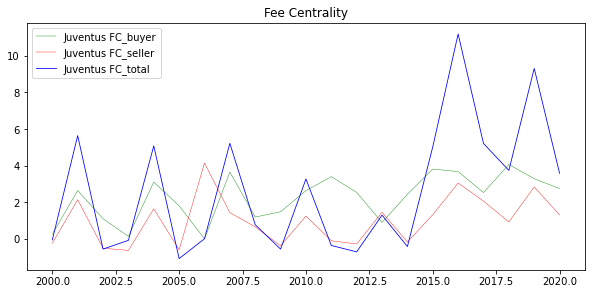

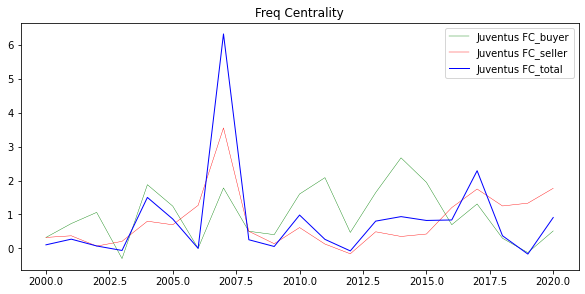

In [187]:
_ = get_centrality_years(['Juventus FC'], 'Serie A', 2000, 2020)

I don't know if these graphs for Barca makes sense for you. For sure it seems more stable than Juve and Inter, and knowing the stability of the results of Barca in the last 20 years this doesn't suriprise me.

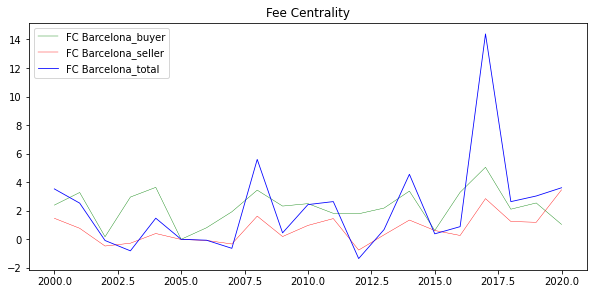

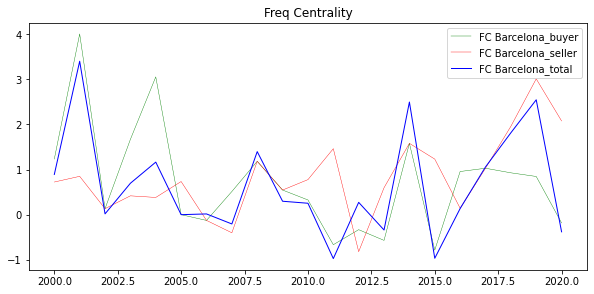

In [188]:
_ = get_centrality_years(['FC Barcelona'], 'Primera Division', 2000, 2020)

In the case of Chelsea I think it's clear that in 2003 Abramovich arrived

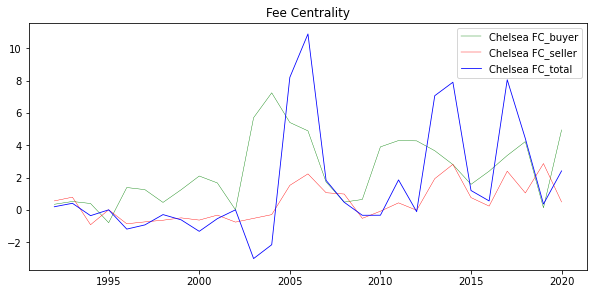

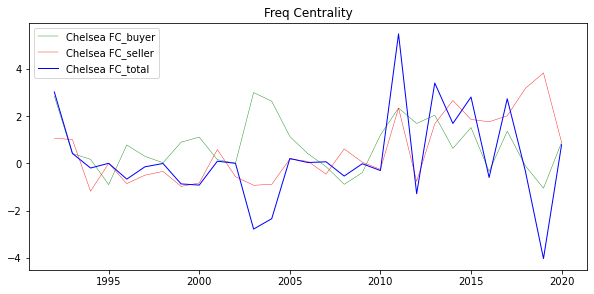

In [189]:
_ = get_centrality_years(['Chelsea FC'], 'Premier League', 1992, 2020)

Notice that you can do comparison just passing more than one teams (but in this case only the total is plotted, not the values for buyer and seller)

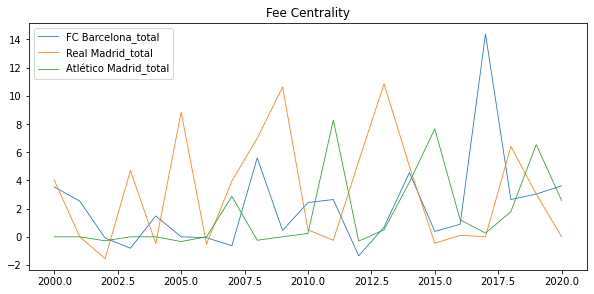

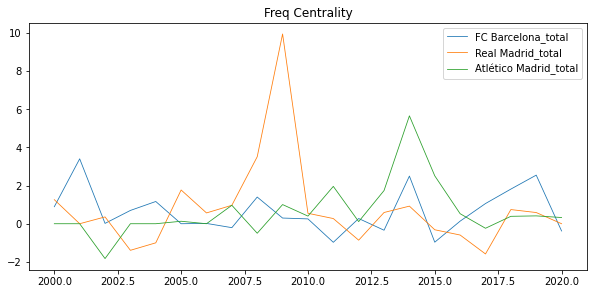

In [190]:
_ = get_centrality_years(['FC Barcelona', 'Real Madrid', 'Atlético Madrid'], 'Primera Division', 2000, 2020)

If we look for the clubs with the higher centrality in all the network, I think that we're gonna retrive those clubs that have a sort of domain in their own leagues (since this measure is realtive to the particular leagues).

In [200]:
g_fee = Graph.Load('nets/1992-2020/fee_net.net'.format(year))
g_freq= Graph.Load('nets/1992-2020/freq_net.net'.format(year))

d = {'fee_buyer':[], 'fee_seller':[], 'fee_total': [], 'freq_buyer':[], 'freq_seller':[], 'freq_total':[]}
for idx, row in leagues.iterrows():
    
    club   = row['club_name']
    league = row['league_name']
    
    league = get_league_teams(league)
    
    z_fee  = get_centrality(g_fee, club, league)
    z_freq = get_centrality(g_freq, club, league)
    
    d['fee_buyer'].append(z_fee[0])
    d['fee_seller'].append(z_fee[1])
    d['fee_total'].append(z_fee[2])
    
    d['freq_buyer'].append(z_freq[0])
    d['freq_seller'].append(z_freq[1])
    d['freq_total'].append(z_freq[2])

Not surpsingly, the teams with the highest centrality are the ones that indeed 'domain' their own leagues, like Benfica, Juventus, Porto, Barcelona, Ajax. Not a lot of teams of the premier league are present (Chelsea and Liverpool), and both of them have a lower value than smaller teams like Roma or Valencia, meaning that probably the premier league is less centrilized.

In [222]:
centrality = leagues
centrality = centrality.join(pd.DataFrame(d))
centrality.sort_values(by='freq_total', ascending=False)[:20]

,club_name,league_name,fee_buyer,fee_seller,fee_total,freq_buyer,freq_seller,freq_total
1112,SL Benfica,Liga Nos,2.413995,4.376596,10.565081,3.750269,2.134409,8.004609
483,FC Internazionale,Serie A,4.475881,2.118028,9.480041,3.162756,2.325316,7.354405
506,FC Porto,Liga Nos,2.252799,4.073266,9.176248,3.619958,2.030160,7.349095
459,FC Barcelona,Primera Division,4.734588,2.430525,11.507537,2.500666,2.798131,6.997192
1043,Real Madrid,Primera Division,4.831746,2.499950,12.079121,2.446582,2.798131,6.845856
716,Juventus FC,Serie A,4.799344,2.880225,13.823191,2.752945,2.432223,6.695774
73,Ajax Amsterdam,Eredivisie,2.552775,4.881766,12.462050,2.822296,2.287186,6.455116
51,AS Monaco,Ligue 1,3.047085,3.504184,10.677545,2.649037,2.264035,5.997513
55,AS Roma,Serie A,2.798058,1.865429,5.219578,3.020213,1.701690,5.139466
1224,Sporting CP,Liga Nos,1.042564,1.980173,2.064456,2.890215,1.587102,4.587065


In [223]:
centrality.sort_values(by='fee_total', ascending=False)[:20]

,club_name,league_name,fee_buyer,fee_seller,fee_total,freq_buyer,freq_seller,freq_total
716,Juventus FC,Serie A,4.799344,2.880225,13.823191,2.752945,2.432223,6.695774
73,Ajax Amsterdam,Eredivisie,2.552775,4.881766,12.462050,2.822296,2.287186,6.455116
1043,Real Madrid,Primera Division,4.831746,2.499950,12.079121,2.446582,2.798131,6.845856
459,FC Barcelona,Primera Division,4.734588,2.430525,11.507537,2.500666,2.798131,6.997192
51,AS Monaco,Ligue 1,3.047085,3.504184,10.677545,2.649037,2.264035,5.997513
1112,SL Benfica,Liga Nos,2.413995,4.376596,10.565081,3.750269,2.134409,8.004609
204,Borussia Dortmund,1 Bundesliga,3.425116,3.072161,10.522507,1.795348,1.228056,2.204788
483,FC Internazionale,Serie A,4.475881,2.118028,9.480041,3.162756,2.325316,7.354405
506,FC Porto,Liga Nos,2.252799,4.073266,9.176248,3.619958,2.030160,7.349095
309,Chelsea FC,Premier League,4.765307,1.785404,8.507999,2.069052,1.891495,3.913600
